In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.decomposition import PCA, FastICA
from pathlib import Path
from enum import Enum

import random
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-xzxhz2zr because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
ROOT_DIR = "/data" if Path("/data").exists() else "."
ROOT_DIR = f"{ROOT_DIR}/figures"
Path(ROOT_DIR).mkdir(exist_ok=True)

## Functions

In [3]:
# comment out if latex support is not installed


import matplotlib as mpl
mpl.use('pgf')
from math import sqrt
default_width = 5.78853
default_ratio = (sqrt(5.0) - 1.0) / 2.0 
mpl.rcParams["text.usetex"] = True
mpl.rcParams["pgf.texsystem"] = "pdflatex"
mpl.rcParams["pgf.rcfonts"] = False
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.sans-serif"] = []
mpl.rcParams["font.monospace"] = []
mpl.rcParams["figure.figsize"] = [default_width, default_width * default_ratio]
%matplotlib inline
plt.close("all")

In [4]:
def set_seeds(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

## Config

In [5]:
class Dist(str, Enum):
    uniform = "uniform"
    laplace = "laplace"


@dataclass
class Config:
    dim: int = 2
    batch_size: int = 32
    epochs: int = 100
    dist: Dist = Dist.uniform


config = Config()
# config = Config(dist=Dist.laplace)
set_seeds(0)

# 2d example

###  Orthogonal mixing (scale + rotate) 


In [6]:
if config.dist == Dist.uniform:
    X0 = np.random.uniform(-np.sqrt(2.0), np.sqrt(2), size=(1000, config.dim))
elif config.dist == Dist.laplace:
    X0 = np.random.laplace(0.0, 1 / np.sqrt(2.0), size=(1000, config.dim))
X = X0

In [7]:
c = plt.cm.twilight_shifted((X0[:, 0] + 1) / 2)
c2 = plt.cm.brg((X0[:, 0] + 1) / 2)
c[X[:, 1] < 0, :] = c2[X[:, 1] < 0, :]


def plot_scatter(y, a=0, b=1, name=None):
    plt.scatter(y[:, a], y[:, b], c=c)
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    if name is not None:
        plt.savefig(f"{ROOT_DIR}/{name}.jpg", dpi=300, bbox_inches="tight")

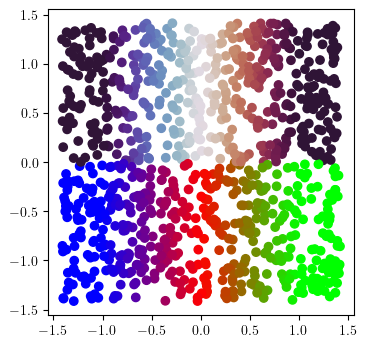

In [8]:
plot_scatter(X0, name=f"{config.dist}-data")

In [9]:
theta = np.pi / 4
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
X = np.dot(X, R)

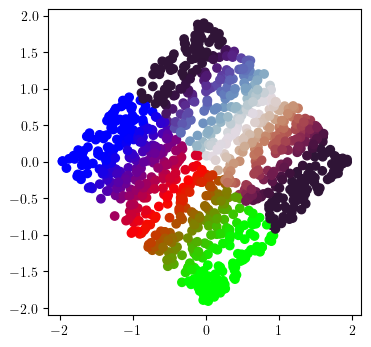

In [10]:
plot_scatter(X, name=f"{config.dist}-rotated-data")

## FastICA

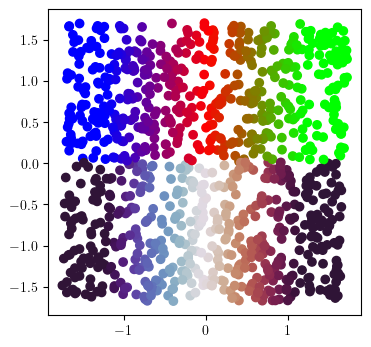

In [11]:
y = FastICA(config.dim, whiten="unit-variance").fit_transform(X)
plot_scatter(y, name=f"{config.dist}-fastica")

## Linear PCA

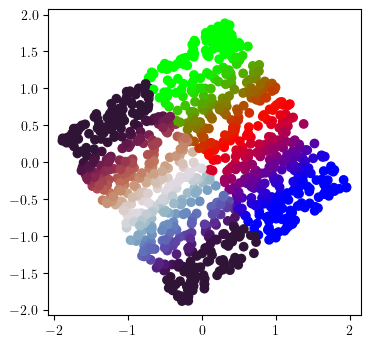

In [12]:
pca = PCA(config.dim)
y = pca.fit_transform(X)
plot_scatter(y, name=f"{config.dist}-lpca")

## Nonlinear PCA

In [13]:
class RecDense(layers.Dense):
    def __init__(self, *args, stop_gradient=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.use_bias = False
        self.stop_gradient = stop_gradient

    def build(self, input_shape):
        super().build(input_shape)
        self.moving_variance = self.add_weight(
            "var", shape=self.units, initializer="ones", trainable=False
        )

    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()

        if training:
            inputs = inputs - tf.reduce_mean(inputs, axis=0)
            kernel = self.kernel
            y = tf.matmul(inputs, self.kernel)
            var = tf.math.reduce_variance(y, axis=0)
            self.moving_variance.assign_add(0.01 * (var - self.moving_variance))

            std = tf.sqrt(1e-3 + self.moving_variance)

            self.add_metric(tf.reduce_max(y), "max")
            self.add_metric(tf.reduce_min(y), "min")
            self.add_metric(tf.math.reduce_variance(y), "var")
            ys = y / std

            yr = std * self.activation(ys)

            dkernel = tf.stop_gradient((kernel)) if self.stop_gradient else kernel
            loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.square(tf.matmul(yr, dkernel, transpose_b=True) - inputs), axis=1
                )
            )
            self.add_loss(loss)

        return tf.matmul(inputs, self.kernel)

Epoch 1/100
32/32 [==============================] - 1s 1ms/step - loss: 0.4355 - max: 1.6171 - min: -1.6326 - var: 0.6736
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4585 - max: 1.5992 - min: -1.6625 - var: 0.6730
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.4724 - max: 1.6196 - min: -1.6210 - var: 0.6747
Epoch 4/100
32/32 [==============================] - 0s 979us/step - loss: 0.4809 - max: 1.5625 - min: -1.5985 - var: 0.6719
Epoch 5/100
32/32 [==============================] - 0s 997us/step - loss: 0.4941 - max: 1.5664 - min: -1.5953 - var: 0.6790
Epoch 6/100
32/32 [==============================] - 0s 980us/step - loss: 0.4945 - max: 1.5662 - min: -1.5692 - var: 0.6728
Epoch 7/100
32/32 [==============================] - 0s 979us/step - loss: 0.5016 - max: 1.5399 - min: -1.5858 - var: 0.6768
Epoch 8/100
32/32 [==============================] - 0s 985us/step - loss: 0.5068 - max: 1.5329 - min: -1.5406 - var: 0.6825
Epoch 

32/32 [==============================] - 0s 935us/step - loss: 0.5018 - max: 1.4136 - min: -1.4027 - var: 0.6795
Epoch 67/100
32/32 [==============================] - 0s 934us/step - loss: 0.4985 - max: 1.3901 - min: -1.3919 - var: 0.6773
Epoch 68/100
32/32 [==============================] - 0s 941us/step - loss: 0.5027 - max: 1.3867 - min: -1.4420 - var: 0.6772
Epoch 69/100
32/32 [==============================] - 0s 941us/step - loss: 0.4998 - max: 1.4331 - min: -1.4151 - var: 0.6708
Epoch 70/100
32/32 [==============================] - 0s 935us/step - loss: 0.5130 - max: 1.4118 - min: -1.3915 - var: 0.6873
Epoch 71/100
32/32 [==============================] - 0s 933us/step - loss: 0.4988 - max: 1.4175 - min: -1.4498 - var: 0.6705
Epoch 72/100
32/32 [==============================] - 0s 925us/step - loss: 0.4949 - max: 1.4000 - min: -1.4072 - var: 0.6727
Epoch 73/100
32/32 [==============================] - 0s 928us/step - loss: 0.4985 - max: 1.4211 - min: -1.4330 - var: 0.6706
Epoch

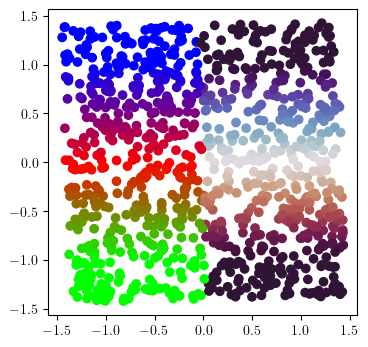

Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1103 - max: 1.3907 - min: -1.4150 - var: 0.6736
Epoch 2/100
32/32 [==============================] - 0s 954us/step - loss: 0.1226 - max: 1.4266 - min: -1.4111 - var: 0.6732
Epoch 3/100
32/32 [==============================] - 0s 959us/step - loss: 0.1323 - max: 1.4203 - min: -1.4226 - var: 0.6747
Epoch 4/100
32/32 [==============================] - 0s 934us/step - loss: 0.1402 - max: 1.4177 - min: -1.4129 - var: 0.6719
Epoch 5/100
32/32 [==============================] - 0s 940us/step - loss: 0.1474 - max: 1.4119 - min: -1.4018 - var: 0.6791
Epoch 6/100
32/32 [==============================] - 0s 921us/step - loss: 0.1506 - max: 1.4092 - min: -1.4063 - var: 0.6728
Epoch 7/100
32/32 [==============================] - 0s 914us/step - loss: 0.1556 - max: 1.4150 - min: -1.3888 - var: 0.6766
Epoch 8/100
32/32 [==============================] - 0s 911us/step - loss: 0.1587 - max: 1.3931 - min: -1.4019 - var: 0.6825
Ep

32/32 [==============================] - 0s 931us/step - loss: 0.1649 - max: 1.4056 - min: -1.4164 - var: 0.6792
Epoch 67/100
32/32 [==============================] - 0s 996us/step - loss: 0.1621 - max: 1.3874 - min: -1.3896 - var: 0.6771
Epoch 68/100
32/32 [==============================] - 0s 1ms/step - loss: 0.1659 - max: 1.4416 - min: -1.3857 - var: 0.6771
Epoch 69/100
32/32 [==============================] - 0s 959us/step - loss: 0.1666 - max: 1.4156 - min: -1.4246 - var: 0.6706
Epoch 70/100
32/32 [==============================] - 0s 933us/step - loss: 0.1690 - max: 1.3885 - min: -1.4085 - var: 0.6871
Epoch 71/100
32/32 [==============================] - 0s 958us/step - loss: 0.1676 - max: 1.4502 - min: -1.4119 - var: 0.6702
Epoch 72/100
32/32 [==============================] - 0s 954us/step - loss: 0.1624 - max: 1.4116 - min: -1.3907 - var: 0.6725
Epoch 73/100
32/32 [==============================] - 0s 956us/step - loss: 0.1654 - max: 1.4197 - min: -1.4230 - var: 0.6704
Epoch 7

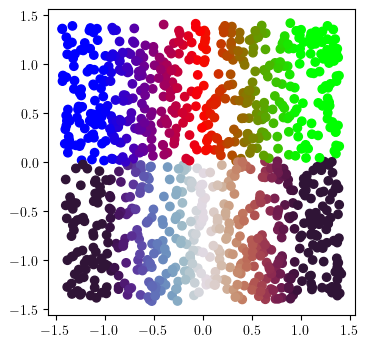

Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0229 - max: 1.6705 - min: -1.6992 - var: 0.6735
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0265 - max: 1.6514 - min: -1.7476 - var: 0.6730
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0305 - max: 1.7165 - min: -1.7437 - var: 0.6747
Epoch 4/100
32/32 [==============================] - 0s 985us/step - loss: 0.0314 - max: 1.6771 - min: -1.6943 - var: 0.6720
Epoch 5/100
32/32 [==============================] - 0s 991us/step - loss: 0.0338 - max: 1.6704 - min: -1.7451 - var: 0.6789
Epoch 6/100
32/32 [==============================] - 0s 984us/step - loss: 0.0354 - max: 1.7024 - min: -1.7033 - var: 0.6727
Epoch 7/100
32/32 [==============================] - 0s 946us/step - loss: 0.0370 - max: 1.6880 - min: -1.7571 - var: 0.6767
Epoch 8/100
32/32 [==============================] - 0s 940us/step - loss: 0.0378 - max: 1.6874 - min: -1.7354 - var: 0.6823
Epoch 

32/32 [==============================] - 0s 935us/step - loss: 0.0397 - max: 1.6718 - min: -1.7273 - var: 0.6792
Epoch 67/100
32/32 [==============================] - 0s 981us/step - loss: 0.0398 - max: 1.6798 - min: -1.7012 - var: 0.6770
Epoch 68/100
32/32 [==============================] - 0s 999us/step - loss: 0.0398 - max: 1.7053 - min: -1.7250 - var: 0.6769
Epoch 69/100
32/32 [==============================] - 0s 969us/step - loss: 0.0391 - max: 1.7251 - min: -1.6971 - var: 0.6705
Epoch 70/100
32/32 [==============================] - 0s 927us/step - loss: 0.0411 - max: 1.6811 - min: -1.7221 - var: 0.6869
Epoch 71/100
32/32 [==============================] - 0s 929us/step - loss: 0.0391 - max: 1.6791 - min: -1.7255 - var: 0.6702
Epoch 72/100
32/32 [==============================] - 0s 903us/step - loss: 0.0401 - max: 1.6677 - min: -1.7739 - var: 0.6725
Epoch 73/100
32/32 [==============================] - 0s 913us/step - loss: 0.0389 - max: 1.6710 - min: -1.7386 - var: 0.6704
Epoch

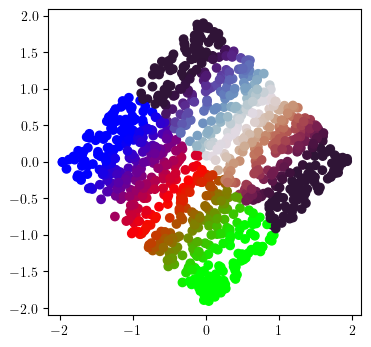

Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0044 - max: 1.5912 - min: -1.5628 - var: 0.6735
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0051 - max: 1.6247 - min: -1.5609 - var: 0.6730
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0063 - max: 1.6460 - min: -1.6096 - var: 0.6747
Epoch 4/100
32/32 [==============================] - 0s 988us/step - loss: 0.0067 - max: 1.6085 - min: -1.5973 - var: 0.6719
Epoch 5/100
32/32 [==============================] - 0s 984us/step - loss: 0.0073 - max: 1.6471 - min: -1.6021 - var: 0.6789
Epoch 6/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0079 - max: 1.6262 - min: -1.6267 - var: 0.6727
Epoch 7/100
32/32 [==============================] - 0s 995us/step - loss: 0.0085 - max: 1.6892 - min: -1.6263 - var: 0.6767
Epoch 8/100
32/32 [==============================] - 0s 989us/step - loss: 0.0088 - max: 1.6732 - min: -1.6202 - var: 0.6823
Epoch 9/

32/32 [==============================] - 0s 933us/step - loss: 0.0107 - max: 1.7273 - min: -1.6719 - var: 0.6792
Epoch 67/100
32/32 [==============================] - 0s 944us/step - loss: 0.0107 - max: 1.7014 - min: -1.6798 - var: 0.6770
Epoch 68/100
32/32 [==============================] - 0s 954us/step - loss: 0.0108 - max: 1.7250 - min: -1.7054 - var: 0.6769
Epoch 69/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0106 - max: 1.6972 - min: -1.7250 - var: 0.6705
Epoch 70/100
32/32 [==============================] - 0s 954us/step - loss: 0.0111 - max: 1.7221 - min: -1.6812 - var: 0.6869
Epoch 71/100
32/32 [==============================] - 0s 970us/step - loss: 0.0106 - max: 1.7258 - min: -1.6791 - var: 0.6702
Epoch 72/100
32/32 [==============================] - 0s 977us/step - loss: 0.0109 - max: 1.7739 - min: -1.6678 - var: 0.6725
Epoch 73/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0105 - max: 1.7388 - min: -1.6711 - var: 0.6704
Epoch 74/

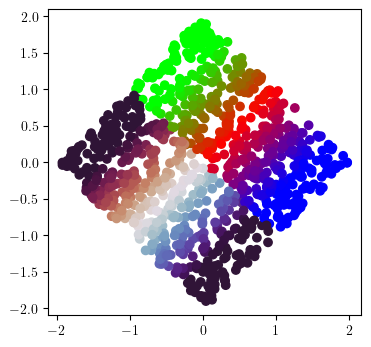

Epoch 1/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0013 - max: 1.5516 - min: -1.4858 - var: 0.6735 
Epoch 2/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0016 - max: 1.5544 - min: -1.5274 - var: 0.6731
Epoch 3/100
32/32 [==============================] - 0s 1ms/step - loss: 0.0018 - max: 1.5781 - min: -1.5541 - var: 0.6747
Epoch 4/100
32/32 [==============================] - 0s 962us/step - loss: 0.0019 - max: 1.5142 - min: -1.5545 - var: 0.6719
Epoch 5/100
32/32 [==============================] - 0s 974us/step - loss: 0.0022 - max: 1.5760 - min: -1.5152 - var: 0.6789
Epoch 6/100
32/32 [==============================] - 0s 957us/step - loss: 0.0023 - max: 1.5836 - min: -1.5801 - var: 0.6728
Epoch 7/100
32/32 [==============================] - 0s 940us/step - loss: 0.0025 - max: 1.5965 - min: -1.5524 - var: 0.6767
Epoch 8/100
32/32 [==============================] - 0s 947us/step - loss: 0.0026 - max: 1.6062 - min: -1.5797 - var: 0.6823
Epoch

32/32 [==============================] - 0s 965us/step - loss: 0.0038 - max: 1.6774 - min: -1.7200 - var: 0.6792
Epoch 67/100
32/32 [==============================] - 0s 950us/step - loss: 0.0039 - max: 1.7309 - min: -1.6855 - var: 0.6770
Epoch 68/100
32/32 [==============================] - 0s 959us/step - loss: 0.0039 - max: 1.7132 - min: -1.7060 - var: 0.6769
Epoch 69/100
32/32 [==============================] - 0s 952us/step - loss: 0.0038 - max: 1.6908 - min: -1.6400 - var: 0.6705
Epoch 70/100
32/32 [==============================] - 0s 968us/step - loss: 0.0040 - max: 1.7317 - min: -1.6891 - var: 0.6869
Epoch 71/100
32/32 [==============================] - 0s 994us/step - loss: 0.0038 - max: 1.7347 - min: -1.6655 - var: 0.6702
Epoch 72/100
32/32 [==============================] - 0s 987us/step - loss: 0.0039 - max: 1.7477 - min: -1.6976 - var: 0.6725
Epoch 73/100
32/32 [==============================] - 0s 989us/step - loss: 0.0038 - max: 1.7220 - min: -1.7012 - var: 0.6704
Epoch

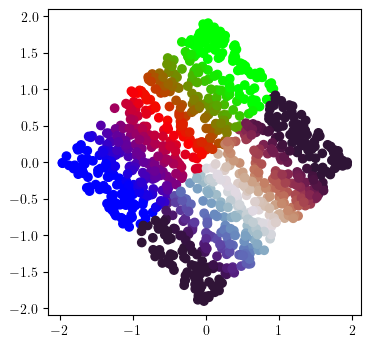

In [14]:
for s in [0.5, 1, 2, 3, 4]:
    tf.keras.backend.clear_session()
    dense = RecDense(
        config.dim,
        kernel_constraint=keras.constraints.UnitNorm([0]),
        kernel_initializer=keras.initializers.Orthogonal(),
        activation=lambda a: s * tf.nn.tanh(a / s),
    )

    model = keras.Sequential(dense)

    model.compile(keras.optimizers.SGD(1e-2, 0.9))
    model.fit(
        X,
        epochs=config.epochs,
        batch_size=config.batch_size,
    )
    y = model(X).numpy()
    plot_scatter(y, name=f"{config.dist}-nlpca-s{s}")
    plt.show()
    plt.close("all")